_Neural Data Analysis_

Lecturer: Prof. Dr. Philipp Berens

Tutors: Sarah Strauss, Ziwei Huang

Summer term 2021

Student names: *FILL IN YOUR NAMES HERE*

# Coding Lab 2

If needed, download the data files ```nda_ex_1_*.npy``` from ILIAS and save it in the subfolder ```../data/```. Use a subset of the data for testing and debugging. But be careful not to make it too small, since the algorithm may fail to detect small clusters in this case. 

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from scipy import signal
from sklearn.cluster import KMeans
import scipy as sp
from scipy.io import loadmat
import copy
from scipy import linalg
from scipy import stats

sns.set_style('whitegrid')
%matplotlib inline

In [2]:
np.random.seed(42)

## Load data

In [3]:
# replace by path to your solutions
b = np.load('../data/nda_ex_1_features.npy')
s = np.load('../data/nda_ex_1_spiketimes_s.npy')
w = np.load('../data/nda_ex_1_waveforms.npy')

## Task 1: Generate toy data

Sample 1000 data points from a two dimensional mixture of Gaussian model with three clusters  and the following parameters:

$\mu_1 = \begin{bmatrix}0\\0\end{bmatrix}, \Sigma_1 = \begin{bmatrix}1 & 0\\0 & 1\end{bmatrix}, \pi_1=0.3$

$\mu_2 = \begin{bmatrix}5\\1\end{bmatrix}, \Sigma_2 = \begin{bmatrix}2 & 1\\1 & 2\end{bmatrix}, \pi_2=0.5$

$\mu_3 = \begin{bmatrix}0\\4\end{bmatrix}, \Sigma_3 = \begin{bmatrix}1 & -0.5\\-0.5 & 1\end{bmatrix}, \pi_3=0.2$

Plot the sampled data points and indicate in color the cluster each point came from. Plot the cluster means as well.

*Grading: 1 pts*


In [4]:
def sampleData(N, m, S, p):
    #    Generate N samples from a Mixture of Gaussian distribution with
    #    means m, covariances S and priors p. The function returns the sampled
    #    datapoints x as well as an indicator for the cluster the point 
    #    originated from. The number of samples is rounded to the nearest integer.
    #
    #    m     #components x #dim
    #    S     #dim x #dim x #components
    #    p     #components
    #
    #    x     N x #dim
    #    ind   N 

    def samplePoint():
        num_clusters = len(p)
        cluster_idx = np.random.choice(num_clusters, p=p)
        cluster_mean = m[cluster_idx]
        cluster_S = S[:, :, cluster_idx]
        
        sample = np.random.multivariate_normal(cluster_mean, cluster_S)
        
        return (sample, cluster_idx)
    
    x, ind = zip(*[samplePoint() for _ in range(N)])
    
    return (np.array(x), np.array(ind))

Specify parameters of Gaussians and run function

In [5]:
N = 1000
m = np.array([[0, 0], [5, 1], [0, 4]])
S1 = np.array([[1, 0], [0, 1]])
S2 = np.array([[2, 1], [1, 2]])
S3 = np.array([[1, -.5], [-.5, 1]])
S = np.concatenate((S1[:,:,np.newaxis],
                    S2[:,:,np.newaxis],
                    S3[:,:,np.newaxis]), axis=2)

p = np.array([.3, .5, .2])

x, ind = sampleData(N, m, S, p)

Plot the toy dataset

(-4.0, 10.0)

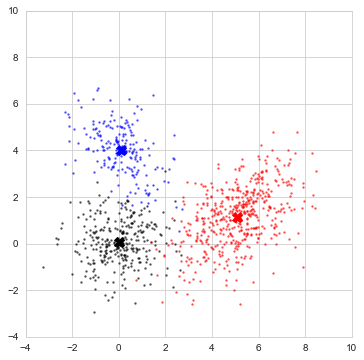

In [6]:
plt.figure(figsize=(6, 6))

ax = plt.subplot(1,1,1, aspect='equal')
plt.plot(x[ind==0,0],x[ind==0,1],'.k', markersize=3, alpha=0.5) 
plt.plot(x[ind==1,0],x[ind==1,1],'.r', markersize=3, alpha=0.5) 
plt.plot(x[ind==2,0],x[ind==2,1],'.b', markersize=3, alpha=0.5)

plt.plot(np.mean(x[ind==0, 0]), np.mean(x[ind==0, 1]), '.k', markersize=10, marker='X')
plt.plot(np.mean(x[ind==1, 0]), np.mean(x[ind==1, 1]), '.r', markersize=10, marker='X')
plt.plot(np.mean(x[ind==2, 0]), np.mean(x[ind==2, 1]), '.b', markersize=10, marker='X')


plt.xlim((-4,10))
plt.ylim((-4,10))


## Task 2: Implement a Gaussian mixture model

Implement the EM algorithm to fit a Gaussian mixture model in `mog()`.  Sort the data points by inferring their class labels from your mixture model (by using maximum a-posteriori classification). Fix the seed of the random number generator to ensure deterministic and reproducible behavior. Test it on the toy dataset specifying the correct number of clusters and make sure the code works correctly. Plot the data points from the toy dataset and indicate in color the cluster each point was assigned to by your model. How does the assignment compare to ground truth? If you run the algorithm multiple times, you will notice that some solutions provide suboptimal clustering solutions - depending on your initialization strategy.  

*Grading: 4 pts*


In [23]:
def mog(x,k):
    # Fit Mixture of Gaussian model
    #   ind, m, S, p = mog(x,k) fits a Mixture of Gaussian model to the data in
    #   x using k components. The output ind contains the MAP assignments of the
    #   datapoints in x to the found clusters. The outputs m, S, p contain
    #   the model parameters.
    #
    #   x:     N by D
    #
    #   ind:   N by 1
    #   m:     k by D
    #   S:     D by D by k
    #   p:     k by 1

#     np.random.seed(42)

    # initialization
    N = np.shape(x)[0]
    D = np.shape(x)[1]
    
    kmeans = KMeans(n_clusters=k,random_state=None).fit(x)
    ind = kmeans.labels_
    m = kmeans.cluster_centers_ + np.random.rand(k, D)
    
    #determine initial coavariance matrix from data covariance
    S = np.zeros((k, D,D))
    for i in range(k):
        S[i, :,:] = np.cov(x,rowvar=False) + np.random.rand(D, D)

    p = [np.size(ind==i) for i in range(k)]
#     p = np.array([1/k]*k)
#     m = x[np.random.choice(np.shape(x)[0], size=k), :]
    N = np.shape(x)[0]
    D = np.shape(x)[1]
#     S = np.array([np.eye(D)]*k)
    gamma = np.zeros((k, N))
    
    for step in range(3):
        # E-step
        def update_gamma_all_clusters(n):
            likelihoods = [stats.multivariate_normal.pdf(x[n, :], mean=m[cluster_idx, :], cov=S[cluster_idx, :, :]) for cluster_idx in range(k)]
            gamma[:, n] = np.multiply(p, likelihoods)/np.sum(np.multiply(p, likelihoods))

        [update_gamma_all_clusters(i) for i in range(N)]
        ind = np.array([np.argmax(gamma[:, i]) for i in range(N)])

        # M-step
        for cluster_idx in range(k):
            N_k = np.sum(gamma[cluster_idx, :])
            m[cluster_idx, :] = np.dot(gamma[cluster_idx, :], x)/N_k
            cov = lambda x: x@(x.T)
            S[cluster_idx, :, :] = np.sum([gamma[cluster_idx, n]*cov((x[n]-m[cluster_idx, :]).reshape(-1, 1)) for n in range(N)], axis=0)/N_k
            p[cluster_idx] = N_k/N

    ind = np.array([np.argmax(gamma[:, i]) for i in range(N)])
    return (ind, m, S, p)

Run Mixture of Gaussian on toy data

In [24]:
ind2, m, S, p = mog(x,3)

Plot toy data with cluster assignments and compare to original labels

Text(0.5, 1.0, 'MoG labels')

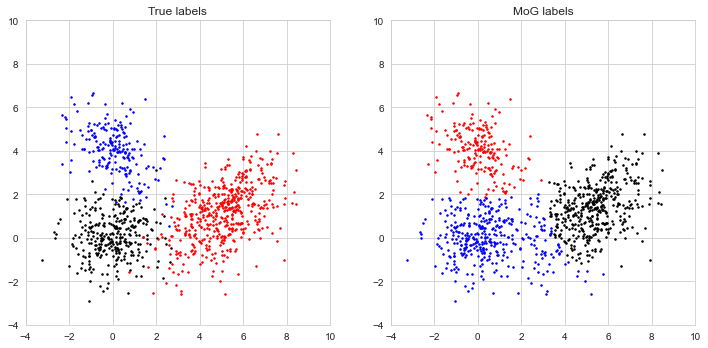

In [25]:
plt.figure(figsize=(12, 6))

ax = plt.subplot(1,2,1, aspect='equal')
plt.plot(x[ind==0,0],x[ind==0,1],'.k', markersize=3) 
plt.plot(x[ind==1,0],x[ind==1,1],'.r', markersize=3) 
plt.plot(x[ind==2,0],x[ind==2,1],'.b', markersize=3)

plt.xlim((-4,10))
plt.ylim((-4,10))
plt.title('True labels')

ax = plt.subplot(1,2,2, aspect='equal')
plt.plot(x[ind2==0,0],x[ind2==0,1],'.k', markersize=3) 
plt.plot(x[ind2==1,0],x[ind2==1,1],'.r', markersize=3) 
plt.plot(x[ind2==2,0],x[ind2==2,1],'.b', markersize=3)

plt.xlim((-4,10))
plt.ylim((-4,10))
plt.title('MoG labels')



## Task 3: Model complexity
A priori we do not how many neurons we recorded. Extend your algorithm with an automatic procedure to select the appropriate number of mixture components (clusters). Base your decision on the Bayesian Information Criterion:

$BIC = -2L+P \log N,$

where $L$ is the log-likelihood of the data under the best model, $P$ is the number of parameters of the model and $N$ is the number of data points. You want to minimize the quantity. Plot the BIC as a function of mixture components. What is the optimal number of clusters on the toy dataset?

You can also use the BIC to make your algorithm robust against suboptimal solutions due to local minima. Start the algorithm multiple times and pick the best solutions for extra points. You will notice that this depends a lot on which initialization strategy you use.

*Grading: 2 pts + 1 extra pt*



In [26]:
def mog_bic(x, m, S, p):
    # Compute the BIC for a fitted Mixture of Gaussian model
    #   bic, LL = mog_bic(x,k) computes the the Bayesian Information 
    #   Criterion value and the log-likelihood of the fitted model.
    #
    #   x:     N by D
    #   m:     k by D
    #   S:     D by D by k

    #   bic:   1 by 1
    #   LL:    1 by 1
    
    k = np.shape(m)[0]
    N = np.shape(x)[0]
    D = np.shape(x)[1]
    P = (k-1) + k*D*(D-1)/2 + k*D
    LL = 0
    
    for point in range(N):
        L = 0
        for cluster_idx in range(k):
            L += p[cluster_idx]*stats.multivariate_normal.pdf(x[point], mean=m[cluster_idx, :], cov=S[cluster_idx, :, :])
        LL += np.log(L)
            
    bic = -2*LL + P*np.log(N)

    return (bic, LL)

Fit and compute the BIC for mixture models with different numbers of clusters (e.g., between 2 and 6).

In [27]:
K = [2, 3, 4, 5, 6]
BIC = np.zeros((3,len(K)))
LL = np.zeros((3,len(K)))

# run mog and BIC multiple times here
for column, k in enumerate(K):
    for trial in range(np.shape(BIC)[0]):
        _, m, S, p = mog(x, k)
        BIC[trial, column], LL[trial, column] = mog_bic(x, m, S, p)

(1.0, 7.0)

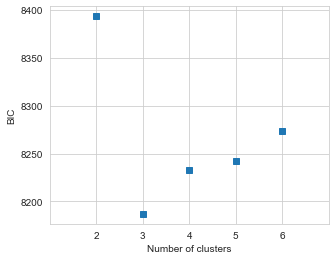

In [28]:
plt.figure(figsize=(5, 4))

plt.plot(K,np.min(BIC,axis=0),'s')
plt.xlabel('Number of clusters')
plt.ylabel('BIC')
plt.xticks(K)
plt.xlim((1,7))

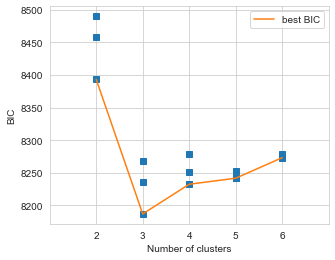

In [29]:
plt.figure(figsize=(5, 4))

plt.plot(np.tile(K, 3),BIC.flatten(),'s')
plt.plot(K,np.min(BIC,axis=0), label='best BIC')
plt.xlabel('Number of clusters')
plt.ylabel('BIC')
plt.xticks(K)
plt.xlim((1,7))
plt.legend()

## Task 4: Spike sorting using Mixture of Gaussian 
Run the full algorithm on your set of extracted features (including model complexity selection). Plot the BIC as a function of the number of mixture components on the real data. For the best model, make scatter plots of the first PCs on all four channels (6 plots). Color-code each data point according to its class label in the model with the optimal number of clusters. In addition, indicate the position (mean) of the clusters in your plot. 

*Grading: 3 pts*


In [13]:
K = np.arange(2,14)
BIC = np.zeros(len(K))
LL = np.zeros(len(K))

for j in np.arange(0,len(K)):
    foo, m, S, p = mog(b,K[j])
    BIC[j], LL[j] = mog_bic(b, m, S, p)

Plot BIC

(1.0, 15.0)

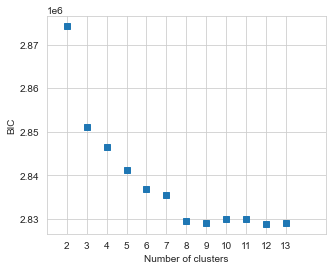

In [14]:
plt.figure(figsize=(5, 4))

plt.plot(K,BIC,'s')
plt.xlabel('Number of clusters')
plt.ylabel('BIC')
plt.xticks(K)
plt.xlim((1,15))

Refit model with lowest BIC and plot data points

In [15]:
k = K[BIC==np.min(BIC)]
ind, m, S, p = mog(b,int(k))


In [17]:
print(k)

[12]


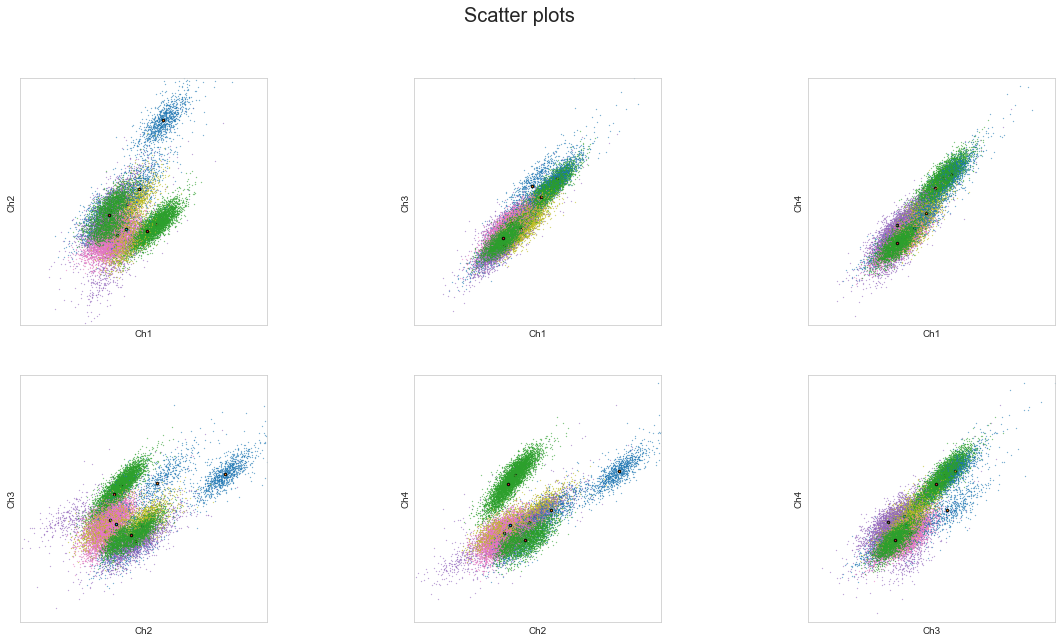

In [49]:
plt.figure(figsize=(20, 10))
plt.suptitle('Scatter plots',fontsize=20)
palette = sns.color_palette("husl", int(k))
idx = [0, 3, 6, 9]
p = 1
labels = ['Ch1','Ch2','Ch3','Ch4']
for i in np.arange(0,4):
    for j in np.arange(i+1,4):
        ax = plt.subplot(2,3,p, aspect='equal')
        for cluster_idx in range(int(k)):
            plt.plot(b[ind==cluster_idx,idx[i]],b[ind==cluster_idx,idx[j]],'.',markersize=0.5)
            plt.plot(m[cluster_idx,idx[i]],m[cluster_idx,idx[j]],'.',markersize=5, mec='k', mew=1) 
        plt.xlabel(labels[i])
        plt.ylabel(labels[j])
        plt.xlim((-900,1200))
        plt.ylim((-900,1200))
        ax.set_xticks([])
        ax.set_yticks([])
        p = p+1

In [ ]:
np.save('../data/nda_ex_2_means',m)
np.save('../data/nda_ex_2_covs',S)
np.save('../data/nda_ex_2_pis',p)
np.save('../data/nda_ex_2_labels',a)